In [11]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


REBUILD_DATA = True # set to true to one once, then back to false unless you want to change something in your training data.

class DogsVSCats():
    IMG_SIZE = 100
    CATS = "kagglecatsanddogs_5340/PetImages/Cat"
    DOGS = "kagglecatsanddogs_5340/PetImages/Dog"
    TESTING = "kagglecatsanddogs_5340/PetImages/Testing"
    LABELS = {CATS: 0, DOGS: 1}
    training_data = []

    catcount = 0
    dogcount = 0

    def make_training_data(self):
        for label in self.LABELS:
            print(label)
            for f in tqdm(os.listdir(label)):
                if "jpg" in f:
                    try:
                        path = os.path.join(label, f)
                        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                        img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                        self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])  # do something like print(np.eye(2)[1]), just makes one_hot 
                        #print(np.eye(2)[self.LABELS[label]])

                        if label == self.CATS:
                            self.catcount += 1
                        elif label == self.DOGS:
                            self.dogcount += 1

                    except Exception as e:
                        pass
                        #print(label, f, str(e))

        np.random.shuffle(self.training_data)
        np.save("training_data1.npy", self.training_data)
        print('Cats:',dogsvcats.catcount)
        print('Dogs:',dogsvcats.dogcount)


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)

        x = torch.randn(100,100).view(-1,1,100,100)
        self._to_linear = None
        self.convs(x)

        self.fc1 = nn.Linear(self._to_linear, 512)
        self.fc2 = nn.Linear(512, 2)

    def convs(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2,2))

        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x

    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)



if torch.cuda.is_available():
    device = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc. 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")




net = Net().to(device)

if REBUILD_DATA:
    dogsvcats = DogsVSCats()
    dogsvcats.make_training_data()

training_data = np.load("training_data1.npy", allow_pickle=True)
training_data = training_data[:10000]
print(len(training_data))

optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

X = torch.Tensor([i[0] for i in training_data]).view(-1, 100, 100)
X = X/255.0
y = torch.Tensor([i[1] for i in training_data])

VAL_PCT = 0.1
val_size = int(len(X)*VAL_PCT)
print(val_size)

train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

print(len(train_X),"HEll")
print(len(test_X))


def train(net):
    BATCH_SIZE = 100
    EPOCHS = 3
    for epoch in range(EPOCHS):
        for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
            batch_X = train_X[i:i+BATCH_SIZE].view(-1,1,100,100)
            batch_y = train_y[i:i+BATCH_SIZE]

            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            net.zero_grad()
            outputs = net(batch_X)
            loss = loss_function(outputs, batch_y)
            loss.backward()
            optimizer.step()
        print(loss)

def test(net):
    correct = 0
    total = 0
    with torch.no_grad():
        for i in tqdm(range(len(test_X))):
            real_class = torch.argmax(test_y[i]).to(device)
            net_out = net(test_X[i].view(-1, 1, 100, 100).to(device))[0]

            predicted_class = torch.argmax(net_out)
            if predicted_class == real_class:
                correct += 1
            total += 1
    print("Accuracy:", round(correct/total,3))

Running on the CPU
kagglecatsanddogs_5340/PetImages/Cat


100%|███████████████████████████████████| 12501/12501 [00:11<00:00, 1051.72it/s]


kagglecatsanddogs_5340/PetImages/Dog


100%|████████████████████████████████████| 12501/12501 [00:12<00:00, 967.65it/s]


Cats: 12476
Dogs: 12470
10000
1000
9000 HEll
1000


In [12]:
net = net.to(device)

def train(net):
    BATCH_SIZE = 100
    EPOCHS = 3
    for epoch in range(EPOCHS):
        for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
            batch_X = train_X[i:i+BATCH_SIZE].view(-1,1,100,100)
            batch_y = train_y[i:i+BATCH_SIZE]

            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            net.zero_grad()
            outputs = net(batch_X)

            matches  = [torch.argmax(i)==torch.argmax(j) for i, j in zip(outputs, batch_y)]
            in_sample_acc = matches.count(True)/len(matches)

            loss = loss_function(outputs, batch_y)
            loss.backward()
            optimizer.step()
        print(loss)
        print("In-sample acc:",round(in_sample_acc, 2))

train(net)

100%|███████████████████████████████████████████| 90/90 [04:47<00:00,  3.20s/it]


tensor(0.2500, grad_fn=<MseLossBackward0>)
In-sample acc: 0.53


100%|███████████████████████████████████████████| 90/90 [04:47<00:00,  3.19s/it]


tensor(0.2501, grad_fn=<MseLossBackward0>)
In-sample acc: 0.47


100%|███████████████████████████████████████████| 90/90 [04:46<00:00,  3.18s/it]

tensor(0.2501, grad_fn=<MseLossBackward0>)
In-sample acc: 0.47


In [13]:
def batch_test(net):
    BATCH_SIZE = 100
    correct = 0
    total = 0
    with torch.no_grad():
        #np.random.shuffle(test_X)
        #np.random.shuffle(test_y)

        batch_X = test_X[:BATCH_SIZE].view(-1,1,100,100)
        batch_y = test_y[:BATCH_SIZE]

        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        net.zero_grad()
        outputs = net(batch_X)

        matches  = [torch.argmax(i)==torch.argmax(j) for i, j in zip(outputs, batch_y)]
        acc = matches.count(True)/len(matches)

        print("Test Accuracy:", round(acc, 3))


batch_test(net)

Test Accuracy: 0.54


### Pytorch Learning

In [1]:
!pip3 install torch torchvision torchaudio

In [1]:
# numpy doesn't run on gpu
# nice gpu have 1000's of cores

In [2]:
import torch

In [3]:
x=torch.Tensor([5,3])
y=torch.Tensor([2,1])

print(x*y)

tensor([10.,  3.])


In [4]:
x= torch.zeros([5,3])
x

tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])

In [5]:
x.shape

torch.Size([5, 3])

In [6]:
y=torch.rand([2,5])
y

tensor([[0.1615, 0.6722, 0.2501, 0.9883, 0.4283],
        [0.8048, 0.5528, 0.1330, 0.2308, 0.1787]])

In [7]:
# just like numpy but for gpu prep many methods are quite different lets see

In [8]:
# like reshape has changed to view

In [9]:
# we have to flatten in first to reshape

In [10]:
y=y.view([1,10])
y.shape

torch.Size([1, 10])

In [11]:
y

tensor([[0.1615, 0.6722, 0.2501, 0.9883, 0.4283, 0.8048, 0.5528, 0.1330, 0.2308,
         0.1787]])

In [12]:
!pip install torchvision

In [13]:
import torch
import torchvision
from torchvision import transforms, datasets

In [14]:
train = datasets.MNIST("", train=True, download=True, transform = transforms.Compose([transforms.ToTensor()]))

test = datasets.MNIST("", train=False, download=True, transform = transforms.Compose([transforms.ToTensor()]))

In [15]:
trainset = torch.utils.data.DataLoader(train,batch_size=10, shuffle=True)
testset = torch.utils.data.DataLoader(test,batch_size=10, shuffle=True)

In [16]:
for data in trainset:
    print((data))
    break

[tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0

In [17]:
x,y =data[0][0], data[1][0]
y

tensor(8)

In [18]:
import matplotlib.pyplot as plt

In [19]:
print(data[0][0].shape)

torch.Size([1, 28, 28])


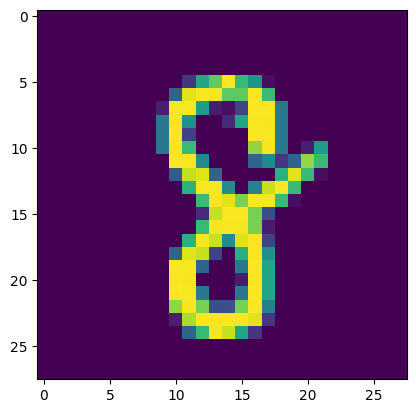

In [20]:
plt.imshow(data[0][0].view(28,28))
plt.show()

In [21]:
total=0
counter_dict={0:0,1:0,2:0,3:0,4:0,5:0,6:0,7:0,8:0,9:0}

for data in trainset:
    xs,ys= data
    for j in ys:
        counter_dict[int(j)]+=1

counter_dict

{0: 5923,
 1: 6742,
 2: 5958,
 3: 6131,
 4: 5842,
 5: 5421,
 6: 5918,
 7: 6265,
 8: 5851,
 9: 5949}

In [22]:
import torch.nn as nn
import torch.nn.functional as F

In [23]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1=nn.Linear(28*28,64)
        self.fc2=nn.Linear(64,64)
        self.fc3=nn.Linear(64,64)
        self.fc4=nn.Linear(64,10)
 # activation function run on the resulting output

    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = (self.fc4(x))     
        return(F.log_softmax(x, dim=1))
        
net = Net()
print(net)

Net(
  (fc1): Linear(in_features=784, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
)


In [24]:
X = torch.rand((28,28))
X=X.view(1,28*28)

In [25]:
output = net(X)

In [26]:
output

tensor([[-2.3210, -2.2873, -2.2866, -2.2771, -2.4156, -2.3391, -2.1921, -2.3273,
         -2.1803, -2.4293]], grad_fn=<LogSoftmaxBackward0>)

In [27]:
import torch.optim as optim

In [28]:
optimizer= optim.Adam(net.parameters(), lr=0.001)

EPOCHS=15

for epoch in range(EPOCHS):
    for data in trainset:
        X,y=data
        net.zero_grad()      
        output = net(X.view(-1,28*28))
        loss = F.nll_loss(output,y)
        loss.backward()
        optimizer.step()
    
    print(loss)

tensor(0.2125, grad_fn=<NllLossBackward0>)
tensor(0.0360, grad_fn=<NllLossBackward0>)


KeyboardInterrupt: 

In [29]:
correct =0
total =0

with torch.no_grad():
    for data in trainset:
        X,y = data
        output = net(x.view(-1,(784)))
        for idx, i in enumerate(output):
            if torch.argmax(i) ==y[idx]:
                     correct+=1
            total += 1
                    
print(round(correct/total,3))

0.103


In [30]:
# CNN PERforming better than rnn in sequential type of data

In [31]:
# Dog and Cat Classifier

In [32]:
# tqdm progress bar